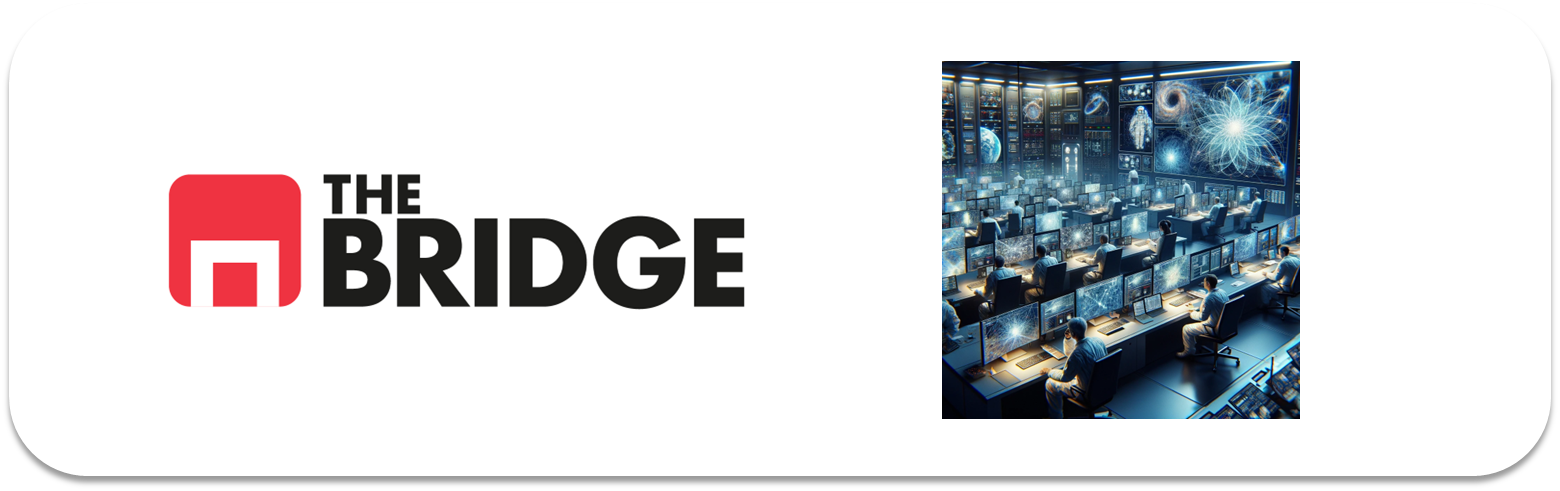

## PRACTICA OBLIGATORIA: **Transfer Learning y Fine Tuning con CNN**

* La práctica obligatoria de esta unidad consiste en un repetir el ejercicio de construcción de un modelo de clasificación de paisajes pero usando un modelo preentrenado. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import cv2
import kagglehub
import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd 
import seaborn as sns
import tensorflow as tf

from keras.applications import InceptionV3
from skimage.io import imread
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from time import time

import gc

c:\Users\hugof\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Objetivo del ejercicio

Comparar una red convolucional hecha ad-hoc frente a los modelos preentrenados y ajustados con fine tuning y transfer learning. Para ello emplea el dataset de paisajes del conjunto de ejercicios de la unidad anterior.


### Se pide

1. Preparar los datos del modelo y las funciones de visualización, copia para ello todo lo que necesites de las soluciones del ejercicio de clasificación de paisajes de la unidad anterior.

2. Escoger entre uno de los modelos VGG-19, InceptionV3 y MobileNetV2 (todos en https://keras.io/api/applications/) (Se aconseja este último si no tenemos un ordenador muy potente). Si no te haces con estos puedes recurrir a la ResNetV50.

4. Hacer un transfer-learning con una cabeza de como mucho 2 capas densas ocultas y una de salida. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

5. Hacer un fine-tuning con la misma cabeza diseñada en el punto anterior. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

6. Comparar los resultados con los obtenidos con la red convolucional del ejercicio mencionado.

EXTRA:
- Repetir el transfer learning empleando aumentado de imágenes.



In [2]:
print('Num GPU Availeable: ', len(tf.config.list_physical_devices('GPU')))
print(tf.test.gpu_device_name())

Num GPU Availeable:  0



In [3]:
path = kagglehub.dataset_download('puneet6060/intel-image-classification')

print('Path to dataset files: ', path)

Path to dataset files:  C:\Users\hugof\.cache\kagglehub\datasets\puneet6060\intel-image-classification\versions\2


In [4]:
ROOT_PATH = path

TRAIN_PATH = ROOT_PATH + '/seg_train/seg_train/'
TEST_PATH = ROOT_PATH + '/seg_test/seg_test/'

In [5]:
os.listdir(TRAIN_PATH)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [6]:
os.listdir(TEST_PATH)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

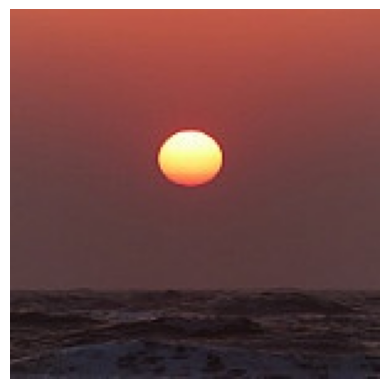

In [7]:
img_path = TRAIN_PATH + '/sea/' + '11321.jpg'

imread(img_path)

img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.axis('off')
plt.show()

In [8]:
IMG_WIDTH = IMG_HEIGH = 75

In [9]:
def read_data(directory, dim_reshape = (IMG_WIDTH, IMG_HEIGH)):
    x = []
    y = []
    

    for folder in os.listdir(directory):
        print(folder)
        if os.path.isdir('/'.join([directory, folder])):
            for file in os.listdir('/'.join([directory, folder])):

                img = imread('/'.join([directory, folder, file]))
                img = cv2.resize(img, dim_reshape)

                x.append(img)
                y.append(folder)

    return np.array(x), np.array(y)

def show_images_batch(landscapes, names = [], n_cols = 5, size_scale = 2):
    n_rows = ((len(landscapes) - 1) // n_cols + 1)
    plt.figure(figsize=(n_cols * size_scale, n_rows * 1.1*size_scale))
    for index, landscape in enumerate(landscapes):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(landscape, cmap = 'Greys')
        plt.axis('off')
        if len(names):
            plt.title(names[index])


In [10]:
X_train, y_train = read_data(TRAIN_PATH)
X_test, y_test = read_data(TEST_PATH)

buildings
forest
glacier
mountain
sea
street
buildings
forest
glacier
mountain
sea
street


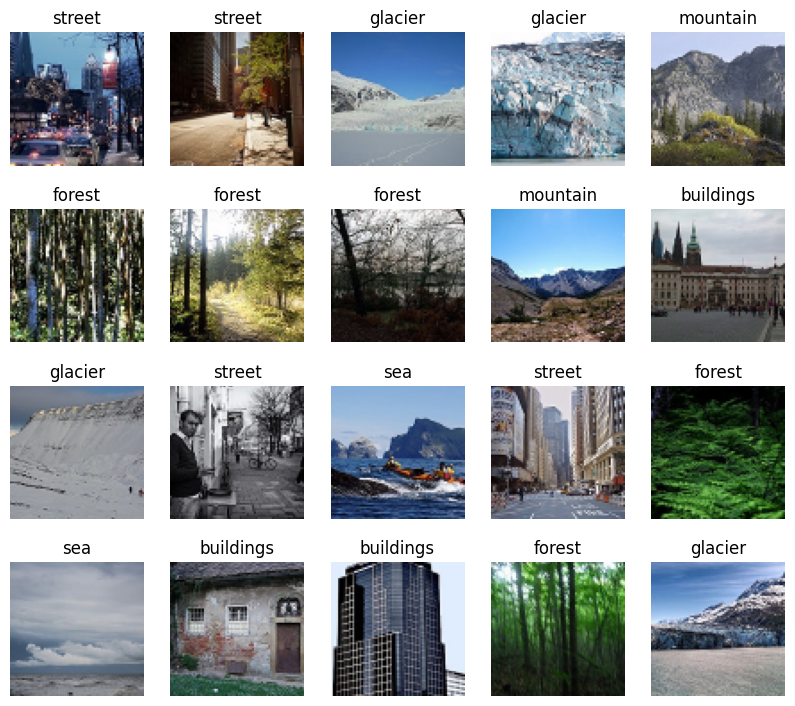

In [11]:
indexes = np.random.randint(0, len(X_train), 20)
show_images_batch(X_train[indexes], names = y_train[indexes], n_cols = 5)

In [12]:
X_train.shape

(14034, 75, 75, 3)

In [13]:
X_train.size

236823750

In [14]:
X_test.shape

(3000, 75, 75, 3)

In [15]:
X_train = X_train/255
X_test = X_test/255

In [16]:
X_train.size

236823750

In [17]:
test_model = InceptionV3(include_top=False, weights = 'imagenet', input_shape=(75,75,3))

In [18]:
test_model.input

<KerasTensor shape=(None, 75, 75, 3), dtype=float32, sparse=False, ragged=False, name=keras_tensor>

In [19]:
test_model.output

<KerasTensor shape=(None, 1, 1, 2048), dtype=float32, sparse=False, ragged=False, name=keras_tensor_310>

In [20]:
del test_model
gc.collect()

1201

In [21]:
IMG_WIDTH = IMG_HEIGH = 75

base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(IMG_WIDTH, IMG_HEIGH, 3))

for layer in base_model.layers:
    layer.trainable = False

def prepare_model(base_model = base_model):

    x = keras.layers.Flatten()(base_model.output)

    x = keras.layers.Dense(2048, activation='relu')(x)
    x = keras.layers.Dropout(rate = 0.25)(x)

    x = keras.layers.Dense(6, activation='softmax')(x)

    model = keras.Model(base_model.input, x)

    model.compile(
        optimizer = 'adam',
        loss = 'sparse_categorical_crossentropy',
        metrics = ['acc']
    )

    return model

model = prepare_model()
model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 75, 75, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_94 (Conv2D)  │ (None, 37, 37,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 37, 37,    │         96 │ conv2d_94[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_94       │ (None, 37, 37,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_95 (Conv2D)  │ (None, 35, 35,    │      9,216 │ activation_94[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │         96 │ conv2d_95[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_95       │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_96 (Conv2D)  │ (None, 35, 35,    │     18,432 │ activation_95[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │        192 │ conv2d_96[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_96       │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 17, 17,    │          0 │ activation_96[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_97 (Conv2D)  │ (None, 17, 17,    │      5,120 │ max_pooling2d_4[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 17, 17,    │        240 │ conv2d_97[0][0]   │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_97       │ (None, 17, 17,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_98 (Conv2D)  │ (None, 15, 15,    │    138,240 │ activation_97[0]… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │        576 │ conv2d_98[0][0]   │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_98       │ (None, 15, 15,    │          0 │ batch_normalizat

 Total params: 26,011,430 (99.23 MB)

 Trainable params: 4,208,646 (16.05 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [22]:
train_instances = len(X_train)

for i in range(1,5):
    print(f'batch_size: {32*i}, num_steps_per_epoch: {round(train_instances*0.8/(32*i))}')

batch_size: 32, num_steps_per_epoch: 351
batch_size: 64, num_steps_per_epoch: 175
batch_size: 96, num_steps_per_epoch: 117
batch_size: 128, num_steps_per_epoch: 88


In [23]:
y_train

array(['buildings', 'buildings', 'buildings', ..., 'street', 'street',
       'street'], dtype='<U9')

In [24]:
targets = pd.Series(y_train)

In [25]:
map_ = {type_:index for index,type_ in enumerate(targets.unique())}
map_

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [27]:
y_train_num = np.array([map_[y] for y in y_train])
y_test_num = np.array([map_[y] for y in y_test])

In [28]:
X_train_shuffle, y_train_shuffle = shuffle(X_train, y_train_num)

In [30]:
for batch_size in [32,64,96,128]:
    t_zero = time()
    model = prepare_model()
    model.fit(X_train,
              y_train_num,
              batch_size= batch_size,
              validation_split = 0.2,
              epochs = 1)
    time_ = round(time() - t_zero, 3)

    del model
    gc.collect()

    print(f'batch_size: {batch_size}, num_steps: {len(X_train)/batch_size}, tiempo 1 epoca: {time_}, tiempo 20 epocas: {time_+20}')

351/351 ━━━━━━━━━━━━━━━━━━━━ 59s 152ms/step - acc: 0.6958 - loss: 0.8587 - val_acc: 0.1265 - val_loss: 12.0621
batch_size: 32, num_steps: 438.5625, tiempo 1 epoca: 63.276, tiempo 20 epocas: 83.27600000000001
176/176 ━━━━━━━━━━━━━━━━━━━━ 43s 221ms/step - acc: 0.6964 - loss: 0.8690 - val_acc: 0.1265 - val_loss: 11.4430
batch_size: 64, num_steps: 219.28125, tiempo 1 epoca: 44.246, tiempo 20 epocas: 64.24600000000001
117/117 ━━━━━━━━━━━━━━━━━━━━ 38s 286ms/step - acc: 0.6522 - loss: 0.9561 - val_acc: 0.1204 - val_loss: 13.1629
batch_size: 96, num_steps: 146.1875, tiempo 1 epoca: 39.316, tiempo 20 epocas: 59.316
88/88 ━━━━━━━━━━━━━━━━━━━━ 36s 356ms/step - acc: 0.6463 - loss: 0.9875 - val_acc: 0.1044 - val_loss: 11.8625
batch_size: 128, num_steps: 109.640625, tiempo 1 epoca: 36.57, tiempo 20 epocas: 56.57


In [31]:
batch_size = 128

In [33]:
earlyS = keras.callbacks.EarlyStopping(patience= 10, restore_best_weights= True)

In [35]:
t_zero = time()
model = prepare_model()
history = model.fit(X_train,
                    y_train_num,
                    batch_size= batch_size,
                    validation_split = 0.2,
                    epochs = 40,
                    callbacks=[earlyS])
time_ = round(time() - t_zero, 3)

Epoch 1/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 38s 369ms/step - acc: 0.6718 - loss: 0.9084 - val_acc: 0.0944 - val_loss: 12.8441
Epoch 2/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 30s 336ms/step - acc: 0.8424 - loss: 0.4211 - val_acc: 0.0926 - val_loss: 11.0468
Epoch 3/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 33s 372ms/step - acc: 0.8828 - loss: 0.3077 - val_acc: 0.0980 - val_loss: 12.2037
Epoch 4/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 30s 339ms/step - acc: 0.9263 - loss: 0.2215 - val_acc: 0.1183 - val_loss: 12.9813
Epoch 5/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 29s 329ms/step - acc: 0.9544 - loss: 0.1503 - val_acc: 0.1204 - val_loss: 15.0330
Epoch 6/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 29s 330ms/step - acc: 0.9751 - loss: 0.0985 - val_acc: 0.1158 - val_loss: 14.7883
Epoch 7/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 29s 330ms/step - acc: 0.9902 - loss: 0.0574 - val_acc: 0.1094 - val_loss: 16.7550
Epoch 8/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 29s 333ms/step - acc: 0.9957 - loss: 0.0346 - val_acc: 0.1154 - val_loss: 17.4836
Epoch 9/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 29

In [36]:
model.evaluate(X_test, y_test_num)

94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - acc: 0.8529 - loss: 0.5975


[2.5593459606170654, 0.6626666784286499]

In [37]:
y_pred = [np.argmax(pred) for pred in model.predict(X_test)]

94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step


In [38]:
inverse_map = {value:key for key, value in map_.items()}

y_test_labels = [inverse_map[y] for y  in y_test_num]
y_pred_labels = [inverse_map[y] for y  in y_pred]

print(classification_report(y_test_labels, y_pred_labels))

              precision    recall  f1-score   support

   buildings       0.52      0.92      0.67       437
      forest       0.88      0.96      0.92       474
     glacier       0.61      0.77      0.68       553
    mountain       0.66      0.71      0.68       525
         sea       0.74      0.66      0.70       510
      street       0.00      0.00      0.00       501

    accuracy                           0.66      3000
   macro avg       0.57      0.67      0.61      3000
weighted avg       0.57      0.66      0.61      3000



c:\Users\hugof\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\hugof\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\hugof\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

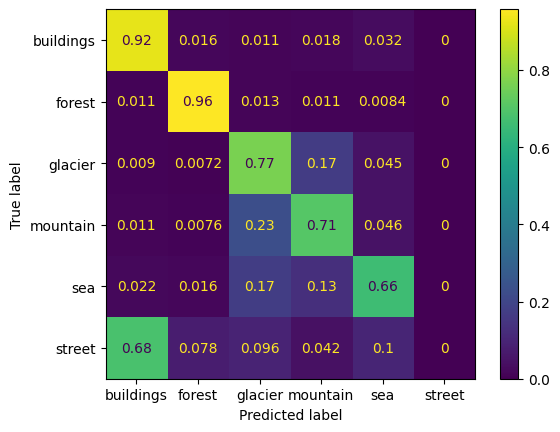

In [39]:
ConfusionMatrixDisplay.from_predictions(y_test_labels, y_pred_labels, normalize = 'true')
plt.show()

In [40]:
del model
del history
gc.collect()

10357

In [42]:
base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(IMG_WIDTH, IMG_HEIGH, 3))

def prepare_model(base_model = base_model):

    x = keras.layers.Flatten()(base_model.output)

    x = keras.layers.Dense(2048, activation='relu')(x)
    x = keras.layers.Dropout(rate = 0.25)(x)

    x = keras.layers.Dense(6, activation='softmax')(x)

    model = keras.Model(base_model.input, x)

    model.compile(
        optimizer = 'adam',
        loss = 'sparse_categorical_crossentropy',
        metrics = ['acc']
    )

    return model

model = prepare_model()
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 75, 75, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_282 (Conv2D) │ (None, 37, 37,    │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 37, 37,    │         96 │ conv2d_282[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_282      │ (None, 37, 37,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_283 (Conv2D) │ (None, 35, 35,    │      9,216 │ activation_282[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │         96 │ conv2d_283[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_283      │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_284 (Conv2D) │ (None, 35, 35,    │     18,432 │ activation_283[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │        192 │ conv2d_284[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_284      │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 17, 17,    │          0 │ activation_284[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_285 (Conv2D) │ (None, 17, 17,    │      5,120 │ max_pooling2d_12… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 17, 17,    │        240 │ conv2d_285[0][0]  │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_285      │ (None, 17, 17,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_286 (Conv2D) │ (None, 15, 15,    │    138,240 │ activation_285[0… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │        576 │ conv2d_286[0][0]  │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_286      │ (None, 15, 15,    │          0 │ batch_normalizat

 Total params: 26,011,430 (99.23 MB)

 Trainable params: 25,976,998 (99.09 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [44]:
for batch_size in [32,64,96,128]:
    t_zero = time()
    model = prepare_model()
    model.fit(X_train,
              y_train_num,
              batch_size= batch_size,
              validation_split = 0.2,
              epochs = 1)
    time_ = round(time() - t_zero, 3)

    del model
    gc.collect()

    print(f'batch_size: {batch_size}, num_steps: {len(X_train)/batch_size}, tiempo 1 epoca: {time_}, tiempo 20 epocas: {time_+20}')

351/351 ━━━━━━━━━━━━━━━━━━━━ 238s 607ms/step - acc: 0.5077 - loss: 1.5269 - val_acc: 0.0499 - val_loss: 14.3458
batch_size: 32, num_steps: 438.5625, tiempo 1 epoca: 246.136, tiempo 20 epocas: 266.13599999999997
176/176 ━━━━━━━━━━━━━━━━━━━━ 185s 917ms/step - acc: 0.6455 - loss: 1.4540 - val_acc: 7.1250e-04 - val_loss: 1340.8475
batch_size: 64, num_steps: 219.28125, tiempo 1 epoca: 191.966, tiempo 20 epocas: 211.966
117/117 ━━━━━━━━━━━━━━━━━━━━ 187s 1s/step - acc: 0.7209 - loss: 1.0755 - val_acc: 0.0563 - val_loss: 92.9117
batch_size: 96, num_steps: 146.1875, tiempo 1 epoca: 193.036, tiempo 20 epocas: 213.036
88/88 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step - acc: 0.7725 - loss: 0.8004 - val_acc: 0.1215 - val_loss: 322.5923
batch_size: 128, num_steps: 109.640625, tiempo 1 epoca: 209.024, tiempo 20 epocas: 229.024


In [46]:
t_zero = time()
model = prepare_model()
history = model.fit(X_train,
                    y_train_num,
                    batch_size= batch_size,
                    validation_split = 0.2,
                    epochs = 40,
                    callbacks=[earlyS])
time_ = round(time() - t_zero, 3)

Epoch 1/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 191s 2s/step - acc: 0.7898 - loss: 0.7368 - val_acc: 0.1322 - val_loss: 2360.3220
Epoch 2/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - acc: 0.8443 - loss: 0.6091 - val_acc: 7.1250e-04 - val_loss: 283.0086
Epoch 3/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - acc: 0.8379 - loss: 0.4860 - val_acc: 0.0837 - val_loss: 243.3853
Epoch 4/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - acc: 0.8253 - loss: 0.7430 - val_acc: 0.1197 - val_loss: 6.8989
Epoch 5/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - acc: 0.8748 - loss: 0.4183 - val_acc: 0.1347 - val_loss: 10.1399
Epoch 6/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - acc: 0.8896 - loss: 0.3334 - val_acc: 0.1332 - val_loss: 9.3435
Epoch 7/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - acc: 0.9082 - loss: 0.2691 - val_acc: 0.1297 - val_loss: 9.8217
Epoch 8/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - acc: 0.9174 - loss: 0.2505 - val_acc: 0.1386 - val_loss: 8.7024
Epoch 9/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step -

In [47]:
model.evaluate(X_test, y_test_num)

94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - acc: 0.7861 - loss: 0.7455


[1.8429596424102783, 0.6586666703224182]

In [48]:
y_pred = [np.argmax(pred) for pred in model.predict(X_test)]

94/94 ━━━━━━━━━━━━━━━━━━━━ 13s 118ms/step


In [49]:
inverse_map = {value:key for key, value in map_.items()}

y_test_labels = [inverse_map[y] for y  in y_test_num]
y_pred_labels = [inverse_map[y] for y  in y_pred]

print(classification_report(y_test_labels, y_pred_labels))

              precision    recall  f1-score   support

   buildings       0.63      0.73      0.67       437
      forest       0.72      0.95      0.82       474
     glacier       0.59      0.92      0.72       553
    mountain       0.80      0.57      0.67       525
         sea       0.63      0.78      0.70       510
      street       0.00      0.00      0.00       501

    accuracy                           0.66      3000
   macro avg       0.56      0.66      0.60      3000
weighted avg       0.56      0.66      0.60      3000



c:\Users\hugof\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\hugof\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\hugof\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

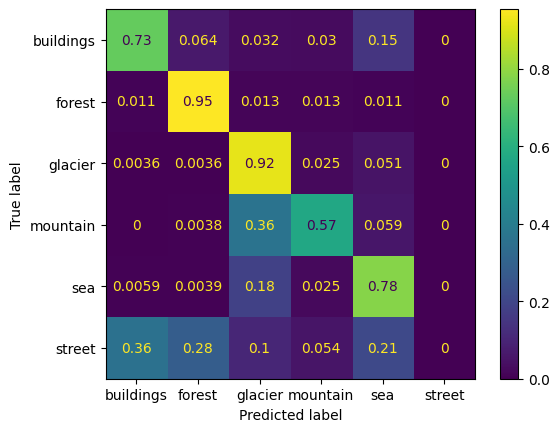

In [50]:
ConfusionMatrixDisplay.from_predictions(y_test_labels, y_pred_labels, normalize = 'true')
plt.show()